# Fitting, Overfitting, and Regularization with Linear Models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from IPython.display import display,Markdown
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use seaborn styling and make font sizes bigger
sns.set(font_scale=1.5)

# Make figures bigger
plt.rcParams.update({'font.size':16,
                     'figure.figsize':(12,10)})

# Make table fonts bigger for slideshow mode
from IPython.display import HTML
HTML("""<style>
table.dataframe {
font-size:150%;
}
</style>""")

In [3]:
# Create instance of each of these classes for later use
linear_regression = LinearRegression()
lasso = Lasso(alpha=2.5e-2, normalize=True, fit_intercept=False)

# Setting random seed for reproducibility across runs
np.random.seed(3)

## What if there is no true relationship at all in your data?

In [4]:
df = pd.DataFrame()

# 100 random, normally-distributed values
df['Relative Mobile Phone Usage'] = np.random.randn(100) 

# The same number of random numbers
noise = np.random.randn(100) 

# Let brain tumor size also be totally random.  Pure noise!
df['Change in Hippocampal Volume'] = noise 

df.head(5)

,Relative Mobile Phone Usage,Change in Hippocampal Volume
0,1.788628,0.874286
1,0.436510,-1.293537
2,0.096497,-0.079741
3,-1.863493,0.564486
4,-0.277388,1.233471


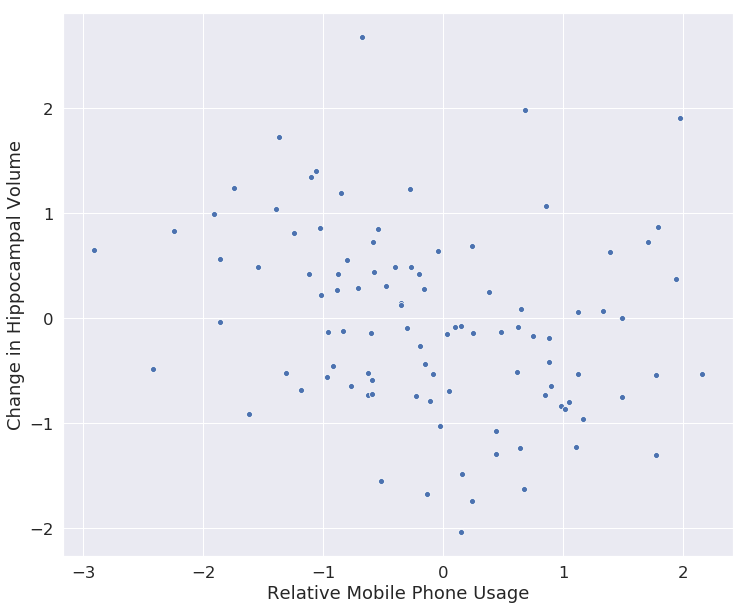

In [5]:
sns.scatterplot(x='Relative Mobile Phone Usage',
                y='Change in Hippocampal Volume',
                data=df);

## You may still get non-zero coefficients

In [6]:
# Specify the X and y values: 
list_of_X_variables = ['Relative Mobile Phone Usage']
X = df[list_of_X_variables]
y = df['Change in Hippocampal Volume']
# Note that I could have, in principle, had more than one X variable
# So ['Mobile Phone Usage'] is a list of X variables (with only one member).

# Fit the linear regression model
linear_regression.fit(X, y)

# Extract the coefficients for the model "y = mx + b"
m = linear_regression.coef_
b = linear_regression.intercept_

# Display the resulting "y = mx + b" equation
Markdown("## [Change in Hippocampal Volume] = %.3g*[Relative Mobile Phone Usage] + %.3g" % (b,m))

## [Change in Hippocampal Volume] = -0.056*[Relative Mobile Phone Usage] + -0.212

### These coefficients are wrong, given that I specified no relationship at all when I generated these data

### One option is to just see if coefficients are "significant" and only keep them in the model if they are

In [7]:
# In this second implementation of linear regression, the "X" values include not only 
# the variable(s) but also the constant. We need to add that constant to the list 
# of "X" values.  
X = add_constant(df[['Relative Mobile Phone Usage']])

# Our y value is the same as before.  
y = df['Change in Hippocampal Volume']

# Fit the model
model = OLS(y, X).fit()

# Summarize the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Change in Hippocampal Volume   R-squared:                       0.066
Model:                                      OLS   Adj. R-squared:                  0.056
Method:                           Least Squares   F-statistic:                     6.925
Date:                          Mon, 08 Apr 2019   Prob (F-statistic):            0.00987
Time:                                  07:47:29   Log-Likelihood:                -125.61
No. Observations:                           100   AIC:                             255.2
Df Residuals:                                98   BIC:                             260.4
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0560      0.086     -0.649      0.518      -0.227       0.115
Relative Mobile Phone Usage    -0.2123      0.081     -2.632      0.010      -0.372      -0.052
==============================================================================
Omnibus:                        4.117   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                3.440
Skew:                           0.384   Prob(JB):                        0.179
Kurtosis:                       3.485   Cond. No.                         1.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Intermezzo on p-values

## What if there is a true relationship in your data, but only for some variables?

In [8]:
df = pd.DataFrame()
df['Mobile Phone Usage'] = np.random.randn(100) # 100 random, normally distributed values
df['Asbestos Exposure'] = np.random.randn(100) # 100 random, normally distributed values

In [9]:
for i in range(3,26):
    df['Thing %d' % i] = np.random.randn(100) # 100 random, normally distributed values

In [10]:
df.head()

,Mobile Phone Usage,Asbestos Exposure,Thing 3,Thing 4,Thing 5,Thing 6,Thing 7,Thing 8,Thing 9,Thing 10,...,Thing 16,Thing 17,Thing 18,Thing 19,Thing 20,Thing 21,Thing 22,Thing 23,Thing 24,Thing 25
0,-0.321585,-1.029710,0.089053,1.815306,1.668025,-0.587844,-0.932924,0.223014,0.034681,0.134640,...,1.399872,-1.784697,0.490430,0.762425,-0.065550,-0.204787,0.457974,0.503371,0.130149,-1.028679
1,0.151130,-1.030209,0.778897,-0.816250,0.259688,-0.869032,-1.240371,0.725729,1.132007,0.812867,...,-1.839809,-0.706705,0.372823,0.092690,-1.808498,0.102038,0.613000,0.098382,0.798783,0.851616
2,-0.018628,-0.612384,1.264645,0.285984,0.110244,-1.506363,0.657913,-0.019378,-2.556727,-0.205514,...,0.607621,0.958038,0.888059,0.286937,1.518549,1.223405,2.447056,0.026385,-1.454176,0.202898
3,0.483529,1.399965,-0.880511,-0.398616,0.579543,-0.107799,-1.832275,0.777623,-0.268957,-0.250335,...,-0.643251,1.131448,0.658398,0.701076,1.272693,2.555874,0.161161,1.874370,-1.153122,0.122363
4,0.768965,-0.849607,0.236406,0.436232,-1.712347,1.000948,0.963271,1.264738,-1.909620,0.672605,...,-0.432156,-0.370319,-0.132705,1.199222,1.150295,0.208555,0.987873,-1.177538,-0.406727,0.496158


In [11]:
df['Change in Hippocampal Volume'] =  (  1*df['Asbestos Exposure'] 
                                       + 3*noise  )

## This relationship is still very noisy

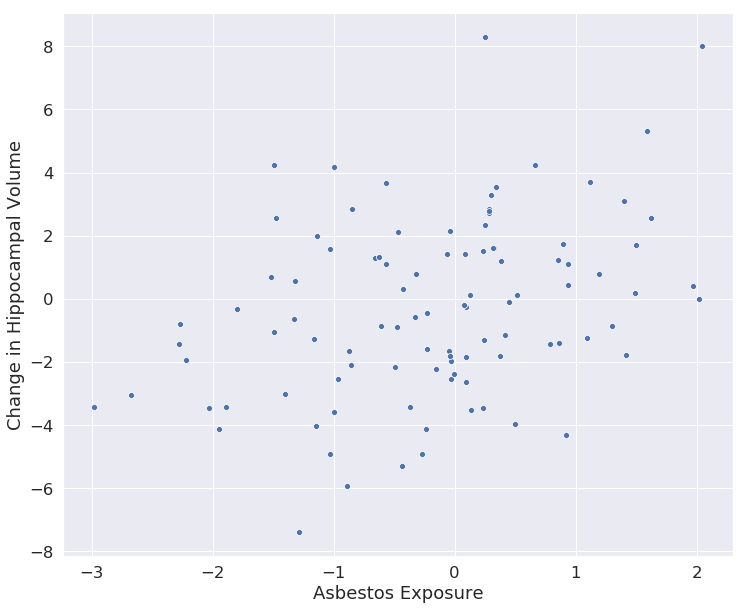

In [12]:
ax = sns.scatterplot(x='Asbestos Exposure', 
                     y='Change in Hippocampal Volume',
                     data=df);

# Fit the plain linear regression model

In [13]:
# y is the same as before
y = df['Change in Hippocampal Volume']

# Specify the full X
X = df.drop('Change in Hippocampal Volume', axis=1)

In [14]:
model = OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Change in Hippocampal Volume   R-squared:                       0.356
Model:                                      OLS   Adj. R-squared:                  0.142
Method:                           Least Squares   F-statistic:                     1.660
Date:                          Mon, 08 Apr 2019   Prob (F-statistic):             0.0486
Time:                                  07:47:30   Log-Likelihood:                -224.36
No. Observations:                           100   AIC:                             498.7
Df Residuals:                                75   BIC:                             563.9
Df Model:                                    25                                         
Covariance Type:                      nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Mobile Phone Usage    -0.0216      0.280     -0.077      0.939      -0.579       0.536
Asbestos Exposure      0.9253      0.275      3.362      0.001       0.377       1.474
Thing 3               -0.5863      0.339     -1.728      0.088      -1.262       0.090
Thing 4                0.4575      0.300      1.524      0.132      -0.141       1.056
Thing 5               -0.1440      0.290     -0.497      0.620      -0.721       0.433
Thing 6               -0.1605      0.338     -0.475      0.636      -0.834       0.513
Thing 7                0.2015      0.297      0.679      0.499      -0.390       0.793
Thing 8                0.4646      0.314      1.481      0.143      -0.160       1.090
Thing 9                0.3288      0.262      1.257      0.213      -0.192       0.850
Thing 10              -0.0872      0.315     -0.277      0.783      -0.715       0.541
Thing 11               0.2215      0.274      0.807      0.422      -0.325       0.768
Thing 12              -0.1741      0.335     -0.519      0.605      -0.842       0.494
Thing 13              -0.2999      0.275     -1.091      0.279      -0.848       0.248
Thing 14              -0.3392      0.317     -1.069      0.288      -0.971       0.293
Thing 15              -0.0978      0.266     -0.368      0.714      -0.627       0.432
Thing 16               0.3303      0.321      1.027      0.308      -0.310       0.971
Thing 17               0.1609      0.343      0.469      0.640      -0.522       0.844
Thing 18              -0.3725      0.286     -1.302      0.197      -0.942       0.197
Thing 19              -0.1899      0.303     -0.626      0.533      -0.794       0.414
Thing 20               0.2358      0.342      0.689      0.493      -0.446       0.918
Thing 21               0.3520      0.310      1.135      0.260      -0.266       0.970
Thing 22               0.2997      0.346      0.865      0.390      -0.390       0.989
Thing 23              -0.3722      0.314     -1.185      0.240      -0.998       0.254
Thing 24               0.0099      0.323      0.031      0.976      -0.634       0.654
Thing 25              -0.2624      0.314     -0.835      0.406      -0.888       0.364
==============================================================================
Omnibus:                        6.670   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.772
Skew:                           0.435   Prob(JB):                       0.0338
Kurtosis:                       3.932   Cond. No.                         2.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matri

## Hmmm, these don't look at all like the right values... shouldn't there be more zeros?

## Some of the coefficients are significant, but not necessarily the right ones, and the values aren't particularly accurate!  

# The Lasso
![lasso](https://gamepedia.cursecdn.com/arksurvivalevolved_gamepedia/e/ea/Lasso.png)

## Regularization, Shrinkage

In [15]:
lasso.alpha = 0.6
lasso.fit(X, y)
m = lasso.coef_
Markdown("## $[Change in Hippocampal Volume] = "+
         " ".join(["%+.3g*[%s]" % (m[i], list(X)[i]) for i in range(25)])+"$")

## $[Change in Hippocampal Volume] = -0*[Mobile Phone Usage] +0.464*[Asbestos Exposure] -0*[Thing 3] +0*[Thing 4] -0*[Thing 5] -0*[Thing 6] +0*[Thing 7] +0*[Thing 8] +0*[Thing 9] +0*[Thing 10] +0*[Thing 11] -0*[Thing 12] -0*[Thing 13] -0*[Thing 14] -0*[Thing 15] +0*[Thing 16] +0*[Thing 17] -0*[Thing 18] -0*[Thing 19] +0*[Thing 20] +0*[Thing 21] +0*[Thing 22] -0*[Thing 23] -0*[Thing 24] -0*[Thing 25]$

## We correctly identified which coefficient(s) drove the true model, and their sign, but underestimated their magnitude

## How does this work?

## The model
### $y = m*x_1 + m*x_2 + m*x_3 + noise$

### Normal regression minimizes:
$y - m*x_1 - m*x_2 - m*x_3 - ...$

### Lasso regression minimizes:
$y - m_1*x_1 - m_2*x_2 - m_3*x_3 + \alpha(|m_1|+|m_2|+|m_3|+...)$

#### There is a tradeoff between fitting the data well and having too many non-zero coefficients

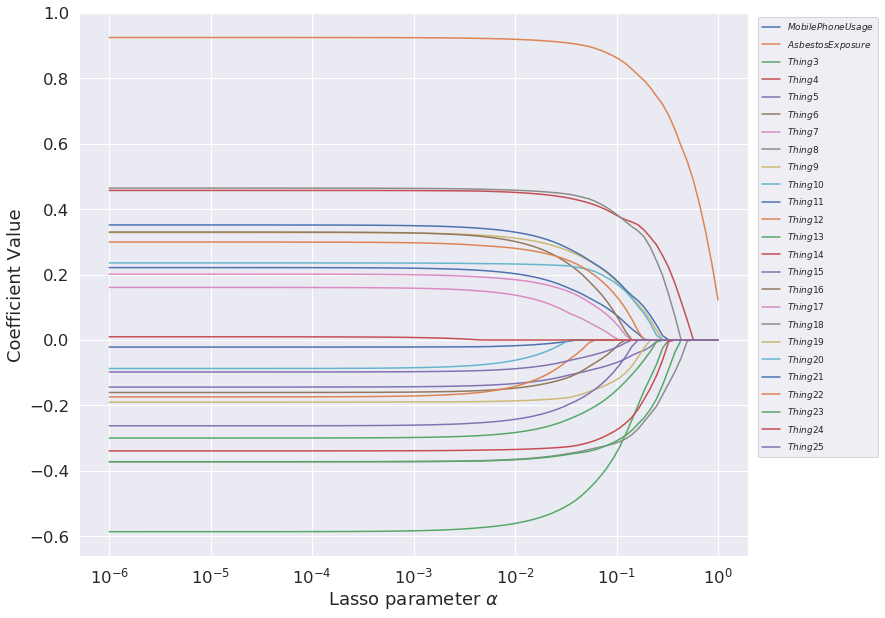

In [16]:
n = 100
coefs = np.empty((n,25))
alphas = np.logspace(-6,0,n)
for i,alpha in enumerate(alphas):
    lasso.alpha = alpha
    lasso.fit(X,y)
    coefs[i,:] = lasso.coef_
plt.plot(alphas,coefs)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$');
plt.ylabel('Coefficient Value');
plt.legend([r'$%s$' % list(X)[i] for i in range(25)], bbox_to_anchor=(1.2, 1), fontsize=9);

### Low values of $\alpha$ allow coefficients to (over)fit the data

### High values of $\alpha$ force coefficients to be zero (to be left out of the model)

## Cross-validation: Checking for overfitting

## Split the data into two groups

### One for fitting the model (training, in-sample)

### The other for checking the model fit (testing, out-of-sample)

In [17]:
# Every third value
df_test = df.iloc[::3] 

# All the rest
df_train = df[~df.index.isin(df_test.index)] 

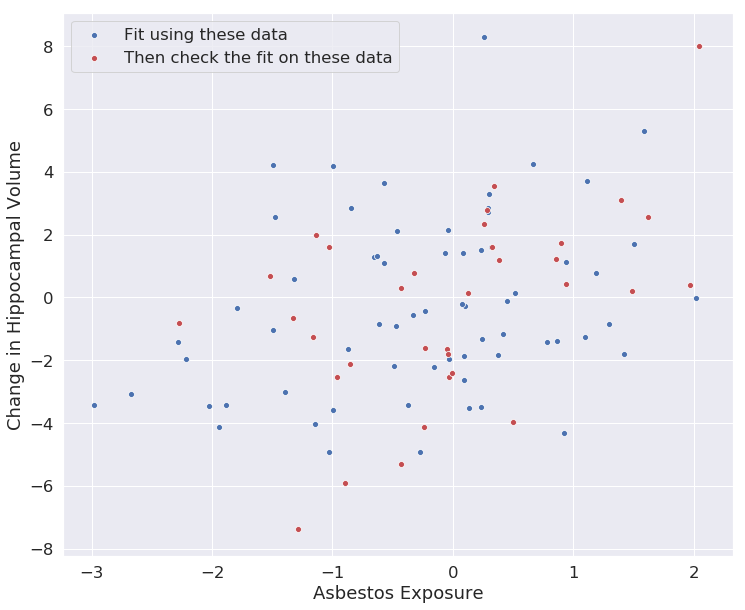

In [18]:
ax = sns.scatterplot(x='Asbestos Exposure', 
                     y='Change in Hippocampal Volume',
                     data=df_train,
                     color='b');
ax = sns.scatterplot(x='Asbestos Exposure', 
                     y='Change in Hippocampal Volume',
                     data=df_test,
                     color='r',
                     ax=ax);
plt.legend(['Fit using these data','Then check the fit on these data']);

In [19]:
def get_prediction(f, df_train, df_test):
    X_train = df_train.drop('Change in Hippocampal Volume', axis=1)
    y_train = df_train['Change in Hippocampal Volume']
    X_test = df_test.drop('Change in Hippocampal Volume', axis=1)
    y_test = df_test['Change in Hippocampal Volume']
    f.fit(X_train,y_train)
    predicted = f.predict(X_test)
    return predicted,y_test

## How well does the model predict the data that it wasn't fit on?  

## We can show how the out-of-sample fit improves as the lasso is tightened

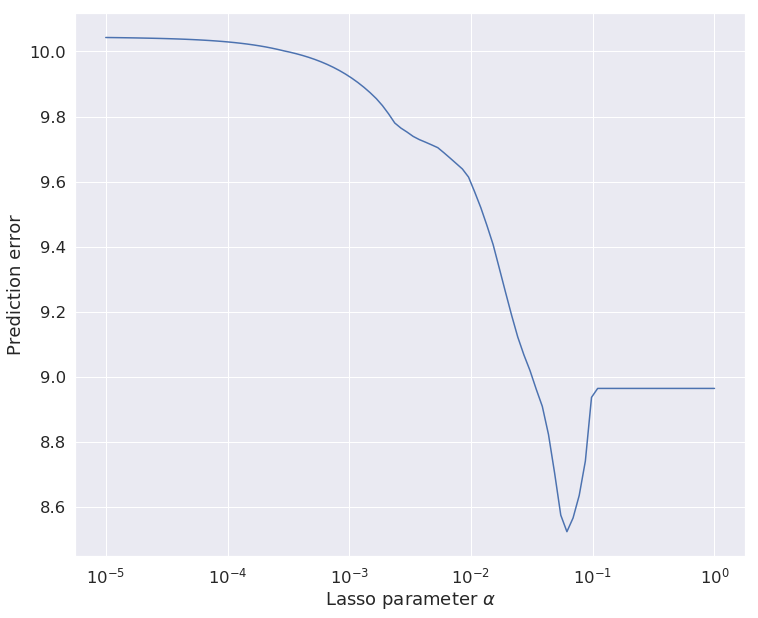

In [20]:
alphas = np.logspace(-5,0,100)
errors = np.empty(100)
for i,alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha,normalize=True)
    predicted,actual = get_prediction(lasso,df_train,df_test)
    errors[i] = np.mean((predicted-actual)**2)
plt.plot(alphas,errors)
plt.xscale('log')
plt.xlabel(r'Lasso parameter $\alpha$');
plt.ylabel('Prediction error');

### The error reduction will get *much* bigger as the number of parameters gets even larger